# Modeling 2

## Libraries

In [1]:
# General libraries for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing and sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Machine Learning Models
from lightgbm import LGBMClassifier  # LightGBM
from xgboost import XGBClassifier    # XGBoost

# Tuning
from sklearn.model_selection import GridSearchCV

# Crossvalidation
from sklearn.model_selection import cross_val_score

# Evaluation Metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Hyperparameter Tuning (if needed)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: numpy._core.multiarray failed to import

# Dataset

In [4]:
df = pd.read_csv(r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\customer_churn_Dec24\data\raw\Customer-Churn-Records.csv")
df = df.drop(['RowNumber', 'CustomerId', 'Surname'],axis = 1)

display(df.head())
display(df.info())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

None

# Data Preparation

In [5]:
# Separate features and target variable
X = df.drop('Exited', axis=1)
y = df['Exited']

# Handle categorical variables 
X_encoded = pd.get_dummies(X, columns=['Geography', 'Gender', 'Card Type'], drop_first=True)

# Train-Test Split with stratification, so that both train and test set maintain the same class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Address imbalances with SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

c:\Users\alexa\anaconda3\envs\customer_churn_Dec24\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\customer_churn_Dec24\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# LGB Classifier

In [6]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Define the model
print("Hyperparameter Tuning for LightGBM...")
lgbm_model = LGBMClassifier(random_state=42)

# Hyperparameter grid to search
param_grid = {
    'num_leaves': [20, 31, 40],                # Number of leaves in a tree
    'learning_rate': [0.01, 0.05, 0.1],        # Step size shrinkage
    'n_estimators': [100, 200, 500],           # Number of boosting iterations
    'max_depth': [-1, 10, 20],                 # Tree depth (-1 means no limit)
    'min_child_samples': [20, 50, 100],        # Minimum number of samples in a child node
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples for each boosting iteration
    'colsample_bytree': [0.6, 0.8, 1.0]        # Fraction of features to consider per boosting iteration
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit the model with training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best estimator and parameters
best_lgbm = grid_search.best_estimator_
print("Best Parameters for LightGBM:", grid_search.best_params_)

# Best Parameters for LightGBM: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 40, 'subsample': 0.6}


Hyperparameter Tuning for LightGBM...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\alexa\anaconda3\envs\customer_churn_Dec24\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [7]:
# Predict using the best model
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print("\n--- LightGBM Evaluation After Tuning ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


--- LightGBM Evaluation After Tuning ---
Accuracy: 0.9985
ROC-AUC Score: 0.9992471548921076

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [7]:
# Now using the best hyperparameters

# 1. LightGBM with Best Parameters
print("Training LightGBM with Best Parameters...")
lgbm_model = LGBMClassifier(
    colsample_bytree=0.6,
    learning_rate=0.05,
    max_depth=10,
    min_child_samples=20,
    n_estimators=500,
    num_leaves=40,
    subsample=0.6,
    random_state=42
)

# Train the model
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]  # Positive class probabilities

# Evaluate the model
print("\n--- LightGBM Evaluation After Hyperparameter Tuning ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

# It did not improve from the first model.it could mean the model is already performing optimally with its default parameters


Training LightGBM with Best Parameters...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

## Cross validation

In [12]:
# Initialize the model with best parameters
lgbm_model = LGBMClassifier(
    colsample_bytree=0.6,
    learning_rate=0.05,
    max_depth=10,
    min_child_samples=20,
    n_estimators=500,
    num_leaves=40,
    subsample=0.6,
    random_state=42
)

# Perform 5-fold cross-validation with ROC-AUC scoring
print("Performing Cross-Validation...")
cv_scores = cross_val_score(lgbm_model, X_train_balanced, y_train_balanced, 
                            cv=5, scoring='roc_auc', n_jobs=-1)

# Print cross-validation results
print("Cross-Validation Scores (ROC-AUC):", cv_scores)
print("Mean ROC-AUC Score:", cv_scores.mean())

# The average ROC-AUC across all folds is 0.99993, which is almost perfect.


Performing Cross-Validation...


c:\Users\alexa\anaconda3\envs\customer_churn_Dec24\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross-Validation Scores (ROC-AUC): [1.         0.99988787 0.99997536 0.99989773 0.99989033]
Mean ROC-AUC Score: 0.9999302558845056


## ROC Curve Visualization



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

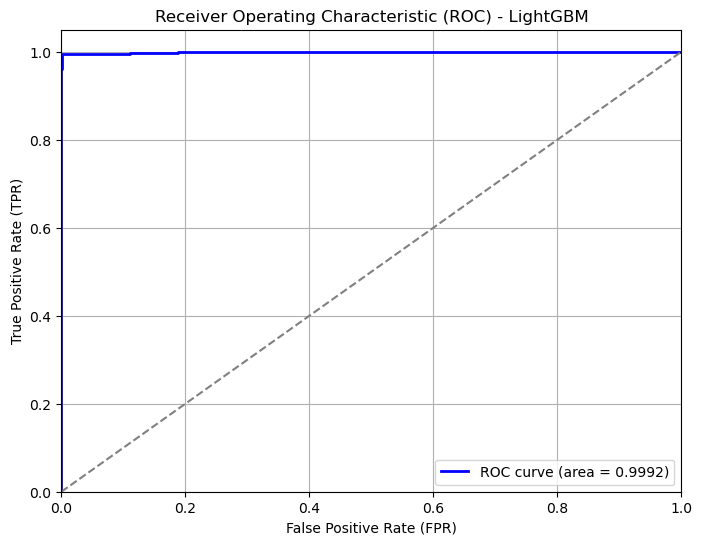

ROC-AUC Score: 0.9992471548921076


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train the model
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities for the positive class
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("ROC-AUC Score:", roc_auc)

# Since the blue curve is far above the diagonal line, the model’s performance is vastly superior to random guessing

## Interpretability - SHAP

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

c:\Users\alexa\anaconda3\envs\customer_churn_Dec24\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


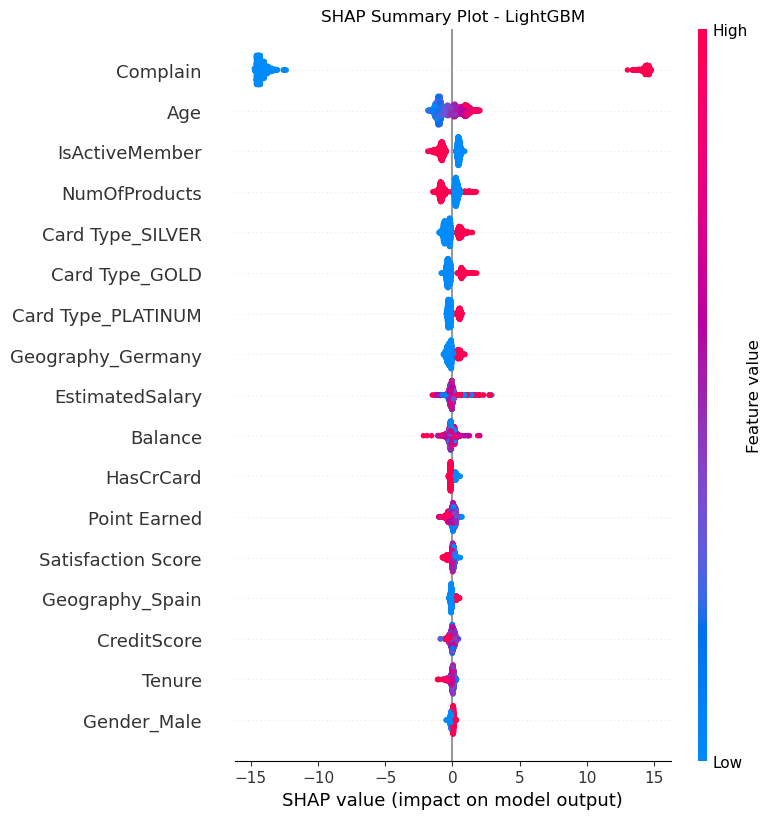

In [9]:
# Ensure SHAP compatibility with LightGBM
shap.initjs()

# Train the model (if not already trained)
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Use TreeExplainer for LightGBM
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
plt.title("SHAP Summary Plot - LightGBM")
shap.summary_plot(shap_values, X_test)

# "Complain" and "Age" are the most influential features for predicting churn, with complaints strongly increasing the probability of churn.
# "IsActiveMember" and "NumOfProducts" confirm expected behavior: active members and those with more products are less likely to churn.